# Strategy Details

### Code Author: Beryl ZHENG

Reference: Jingda Yan, Jialin Yu, "Cross-stock momentum and factor momentum", Journal of Financial Economics, Volumne 150, 2023

Link to reference: 
https://www.sciencedirect.com/science/article/abs/pii/S0304405X23001563?casa_token=tOZzaWrTZ0UAAAAA:X9B_5onttyAuZGZesUej5YY_6ooddQIZMqa3QvACWD6HmCeSfGzqVRq5UeavzSvRfr0LtbfnEKfy

### The Main Idea

- Cross-stock momentum builds on the asymmetry in lead-lag linkages and the difference between long-run and short-run contemporaneous co-movements.
- The asymmetry distinguishes cross-stock momentum from factor momentum, and industry momentum is not subsumed by factor momentum.
- Factor momentum profit is mostly due to the high cross-stock links.

### Differences From the Paper

- In the paper, the authors used the principal portfolio (PP) method and applied singular value decomposition (SVD) of the prediction matrix to build the optimal linear strategy. To simplify the process, we built the prediction matrix using linear regression only and built an equal weight portfolio.
- The data range used in the paper is from 1926 to 2018. In the code below, we used the historical data of S&P500 from 2005 to 2023.

In [1]:
# Collect the list of the S&P 500 companies from Wikipedia and save it to a file
import os
import requests
import pandas as pd

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Get the list of S&P 500 companies from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)
html = response.content
df = pd.read_html(html, header=0)[0]

tickers = df['Symbol'].tolist()

In [2]:
# Load the data from yahoo finance
import os
import yfinance as yf

def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2023-12-31')

        df.to_csv(file_name)

    df = pd.read_csv(file_name, index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    df['date'] = df.index

    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')


BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2005-01-01 -> 2023-12-31)
GEV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SW: Data doesn't exist for startDate = 1104555600, endDate = 1703998800
SOLV: Data doesn't exist for startDate = 1104555600, endDate = 1703998800


Loaded data for 498 companies


### Adding the factor and monthly return
Assuming the we will open at the monthly open price and will close at the monthly close

In [3]:
# We only need the monthly data, so we will resample the data,
# Open should be the first day of the month, Close should be the last day of the month
# High should be the maximum value of the month, Low should be the minimum value of the month
monthly_data = []
for data in holder:
    df = data.resample('M').agg({
        'date': 'first',
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })

    df.set_index('date', inplace=True)

    monthly_data.append(df)

del holder

In [4]:
temp = []
for df in monthly_data:
    # Compute the monthly return   
    df['monthly_return'] = df['Close'].pct_change()
    df['intra_month_return'] = (df['Close'] - df['Open']) / df['Open']
    df['next_intra_month_return'] = df['intra_month_return'].shift(-1)
    # Compute the cumulative return
    df['last_1_month_cumulative_return'] = (1 + df['monthly_return']).cumprod() - 1
    df['last_1_month_cumulative_return'] = df['last_1_month_cumulative_return'].shift(1)    
    df['last_2_month_cumulative_return'] = df['last_1_month_cumulative_return'].shift(1)
    temp.append(df)

monthly_data = temp
    

In [5]:
monthly_data[0].head(3)

,Open,High,Low,Close,Volume,monthly_return,intra_month_return,next_intra_month_return,last_1_month_cumulative_return,last_2_month_cumulative_return
date,,,,,,,,,,
2005-01-03 00:00:00-05:00,38.470288,40.029334,37.796131,39.495602,88466685,NaN,0.026652,0.000136,NaN,NaN
2005-02-01 00:00:00-05:00,39.490942,40.722237,38.835480,39.496304,57967609,0.000018,0.000136,0.020727,NaN,NaN
2005-03-01 00:00:00-05:00,39.501021,41.147879,39.298711,40.319744,66145137,0.020849,0.020727,-0.110814,0.000018,NaN


# Regression Analysis

According to the research paper, we use the cumulative returns to calculate the cross-stock momentum. The cross-stock momentum is calculated by the correlation of the last 1 month cumulative return of stock1 and the last 2 month cumulative return of stock2.

In [6]:
# Transfer all the data to a single dataframe
last_1_month_cumulative_return_holder = []
last_2_month_cumulative_return_holder = []
for symbol, df in zip(tickers, monthly_data):
    last_1_month_cumulative_return_series = df['last_1_month_cumulative_return'].copy().dropna()
    last_2_month_cumulative_return_series = df['last_2_month_cumulative_return'].copy().dropna()

    last_1_month_cumulative_return_series.name = symbol
    last_2_month_cumulative_return_series.name = symbol

    last_1_month_cumulative_return_holder.append(last_1_month_cumulative_return_series)
    last_2_month_cumulative_return_holder.append(last_2_month_cumulative_return_series)

last_1_month_cumulative_return_df = pd.concat(last_1_month_cumulative_return_holder, axis=1)
last_2_month_cumulative_return_df = pd.concat(last_2_month_cumulative_return_holder, axis=1)

print(last_1_month_cumulative_return_df.iloc[0:3, 0:3])
print(last_2_month_cumulative_return_df.iloc[0:3, 0:3])



                                MMM       AOS       ABT
date                                                   
2005-03-01 00:00:00-05:00  0.000018 -0.030616  0.021546
2005-04-01 00:00:00-05:00  0.020867  0.064921  0.035540
2005-05-02 00:00:00-04:00 -0.088976  0.057225  0.098264
                                MMM       AOS       ABT
date                                                   
2005-04-01 00:00:00-05:00  0.000018 -0.030616  0.021546
2005-05-02 00:00:00-04:00  0.020867  0.064921  0.035540
2005-06-01 00:00:00-04:00 -0.088976  0.057225  0.098264


## Build the correlation matrix

To find out the lead-lag linkage, we need to first calculate the correlation. 

We define the cumulative return until month(t-1) of stock i as r_t-1_i, and the cumulative return until month(t) of stock j as r_t_j. We calulate the correlation of r_t-1_i, r_t_j, and the correlation of r_t_i, r_t-1_j. 

If Corr(r_t_i, r_t-1_j) > Corr(r_t-1_i, r_t_j), stock j leads stock i, vice versa. 

In [7]:
correlation_holder = []

for ticker in tickers:
    temp_df = pd.DataFrame()
    temp_df[ticker] = last_1_month_cumulative_return_df[ticker]

    # duplicate the column to the number of tickers so that we can use corrwith later on
    temp_df = pd.concat([temp_df] * len(tickers), axis=1)
    # Change the name of the column to the ticker
    temp_df.columns = tickers

    # Calculate the correlation using corrwith
    correlation_series = temp_df.corrwith(last_2_month_cumulative_return_df, axis=0)
    # Set the correlation_series to the correlation_df as the column
    correlation_holder.append(correlation_series)

In [8]:
correlation_df = pd.concat(correlation_holder, axis=1)
correlation_df.columns = tickers

# Transpose the correlation_df
correlation_df_T = correlation_df.T

correlation_df_T.head(3)

,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WY,WMB,WTW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
MMM,0.990483,0.863347,0.703201,0.107800,0.690091,0.665714,0.387508,0.337023,0.660148,0.668894,...,0.805721,0.587452,0.742860,0.633095,0.775468,0.525698,0.752854,0.639500,0.863734,0.222250
AOS,0.869798,0.991845,0.903065,0.834395,0.924354,0.873726,0.714089,0.604264,0.906104,0.899223,...,0.913631,0.702321,0.931769,0.471259,0.931467,0.907694,0.942870,0.825031,0.900354,0.830995
ABT,0.723312,0.904721,0.995151,0.866151,0.978818,0.971362,0.873378,0.782339,0.905762,0.971497,...,0.836253,0.634746,0.973550,0.323704,0.969226,0.950316,0.959906,0.947298,0.859427,0.979159


Now we have the correlation_df and correlation_df_T

In correlation_df:
- column AAPL, row MMM means the correlation between AAPL and MMM using the last 1 month cumulative return of AAPL and last 2 month cumulative return of MMM
- (MMM, AAPL) = Correlation(AAPL_last_1_month_cumulative_return, MMM_last_2_month_cumulative_return)


In correlation_df_T:
- column AAPL, row MMM means the correlation between AAPL and MMM using the last 2 month cumulative return of AAPL and last 1 month cumulative return of MMM
- (MMM, AAPL) = Correlation(MMM_last_1_month_cumulative_return, AAPL_last_2_month_cumulative_return)

In [9]:
# Get the difference between the correlation_df and correlation_df_T, so that we can know the lead-lag linkage between the companies
correlation_diff =  correlation_df_T - correlation_df

Now, in the correlation_diff: 
- If (MMM, AAPL) > 0,  MMM is following AAPL
- If (MMM, AAPL) < 0,  AAPL is following MMM

In [10]:
# Get the pair of stocks that have the highest correlation difference
correlation_diff_selected_pairs = correlation_diff.stack()
correlation_diff_selected_pairs = correlation_diff_selected_pairs[correlation_diff_selected_pairs > 0.1]
#print(correlation_diff_selected_pairs)
# Save the pairs and the correlation into a holder 
pairs = {}
for symbol in tickers:
    pairs[symbol] = []
    
for pair in correlation_diff_selected_pairs.index:
    # Get the left and right pair
    left, right = pair
    pairs[left].append([right, correlation_diff_selected_pairs[pair]])

As one stock may have multiple leader stocks, we perform the regression analysis based on the leader stock that has the highest correlation difference, which means the stock has the strongest cross-stock momentum

In [11]:
# Sort the pairs based on the correlation difference so that we can select the stock with the highest correlation difference
for symbol in tickers:
    pairs[symbol] = sorted(pairs[symbol], key=lambda x: x[1], reverse=True)

# Add the intra_month_return for the leader stocks to the monthly_data of the lagged stocks
for ticker in tickers:
    if len(pairs[ticker]) > 0:
        monthly_data[tickers.index(ticker)]['intra_month_return' + pairs[ticker][0][0]] = monthly_data[tickers.index(pairs[ticker][0][0])]['intra_month_return']

In [12]:
# Build the regression analysis
regression_data = []
for ticker in tickers:
    if len(pairs[ticker]) > 0:
            
        df = pd.DataFrame()
        df['y'] = monthly_data[tickers.index(ticker)]['next_intra_month_return']
        df['intra_month_retrun'+pairs[ticker][0][0]] = monthly_data[tickers.index(ticker)]['intra_month_return'+pairs[ticker][0][0]]
    
        regression_data.append(df)
            

In [13]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import numpy as np

regression_holder_leader_stock = []
regression_holder_y = []

for df in regression_data:
    df.dropna(inplace=True)
    # X is the second column
    X_leader_stock = df.iloc[:, 1:2]
    # Set the index of X to be the number of the row
    X_leader_stock.index = np.arange(len(X_leader_stock))
    # Set the column name to be "CORR"
    X_leader_stock.columns = ['Leader Stock Intra Month Return']     
    y = df['y']
    # Set the index of y to be the number of the row
    y.index = np.arange(len(y))
    
    regression_holder_leader_stock.append(X_leader_stock)
    
    regression_holder_y.append(y)

regression_df = pd.DataFrame()
# Concatenate all the X and y vertically
regression_df_leader_stock = pd.concat(regression_holder_leader_stock,ignore_index=True)
regression_df_y = pd.concat(regression_holder_y,ignore_index=True)

regression_df = pd.concat([regression_df_leader_stock, regression_df_y], axis=1)

# Fit the regression model for y and CORR
X = sm.add_constant(regression_df['Leader Stock Intra Month Return'])
model = OLS(regression_df['y'], X)
result_corr = model.fit()
print(result_corr.summary())

    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5690
Date:                Mon, 22 Jul 2024   Prob (F-statistic):              0.451
Time:                        10:45:48   Log-Likelihood:                 7124.2
No. Observations:                7082   AIC:                        -1.424e+04
Df Residuals:                    7080   BIC:                        -1.423e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

## Analysis on the regression results

- The coefficient of the leader stock intra-month return is 0.074 with a p-value of 0.451. This suggests that nearly half of the lagged stocks do not generally follow the trends of their leader stocks. This indicates that the lead-lag relationships may not be as strong as expected based on the cross-stock momentum hypothesis. However, we may still derive a regression model for each lagged stocks to predict their future returns based on their leader stocks.

- There are a few potential reasons for this:
    - Smaller sample size: We only used the historical monthly data from 2005 - 2020. The whole sample size may be relatively smaller, which may have limited the ability to reliably detect and quantify the cross-stock momentum effects
    - Data-driven approach limitations: As we used the data-driven methods to identify lead-lag linkages, the approach may be deviated from the definition of cross-stock momentum which is due to some factors like same industry, same supply chain, same location, etc.. 
    - There may be some problems in the code. Please let us know if you find any mistakes. 

### Next Step

Although the p-value is not that satisfactory, it is still worthwile to build a simple trading strategy based on lead-lag linkages.

# Cross-stock Momentum Strategy using data-driven linkages

We first used the stock data from 2005-2017 to identify the leader stocks and the laggard stocks. After determining the leader stocks for each laggard stock, we used the data from 2005-2017 to build multi-variable regression models. The independent variables in these models were the intra-month returns of the leader stocks, and the dependent variable was the next intra-month return of the corresponding laggard stock.

Next, we used these regression models to predict the next intra-month returns of the laggard stocks based on the intra-month returns of the leader stocks from 2018 - 2023.

Based on the predicted next intra-month returns, we then implemented two trading strategies:

- Long-and-short strategy: We took long positions when the predicted next intra-month return was positive, and short positions when the predicted next intra-month return was negative.
- Long-only strategy: We only took long positions when the predicted next intra-month returns were positive.
    
The key steps in this process were:

1. Identifying leader and laggard stocks using 2005-2017 data
2. Building regression models to predict laggard stock returns using leader stock returns
3. Applying the regression models to 2018-2023 data to generate predicted returns
4. Implementing long-and-short and long-only trading strategies based on the predicted returns

In [14]:
# Get the stock price from 2005-2017 and stock price from 2018-2023
last_1_month_cumulative_return_df_2005_2017 = last_1_month_cumulative_return_df.loc['2005-01-01':'2017-12-31']
last_1_month_cumulative_return_df_2018_2023 = last_1_month_cumulative_return_df.loc['2018-01-01':'2023-12-31']

last_2_month_cumulative_return_df_2005_2017 = last_2_month_cumulative_return_df.loc['2005-01-01':'2017-12-31']
last_2_month_cumulative_return_df_2018_2023 = last_2_month_cumulative_return_df.loc['2018-01-01':'2023-12-31']

# Get the dataframe containing the next month return from 2005-2017 and 2018-2023
next_intra_month_return_holder = []
intra_month_return_holder = []
for symbol,df in zip(tickers, monthly_data):
    next_intra_month_return_series = df['next_intra_month_return'].copy().dropna()
    next_intra_month_return_series.name = symbol
    intra_month_return_series = df['intra_month_return'].copy().dropna()
    intra_month_return_series.name = symbol

    next_intra_month_return_holder.append(next_intra_month_return_series)
    intra_month_return_holder.append(intra_month_return_series)

next_intra_month_return_df = pd.concat(next_intra_month_return_holder, axis=1)
intra_month_return_df = pd.concat(intra_month_return_holder, axis=1)

next_intra_month_return_df_2005_2017 = next_intra_month_return_df.loc['2005-01-01':'2017-12-31']
next_intra_month_return_df_2018_2023 = next_intra_month_return_df.loc['2018-01-01':'2023-12-31']

intra_month_return_df_2005_2017 = intra_month_return_df.loc['2005-01-01':'2017-12-31']
intra_month_return_df_2018_2023 = intra_month_return_df.loc['2018-01-01':'2023-12-31']


In [15]:
# Build the correlation matrix for the stock price from 2005-2017
correlation_holder_2005_2017 = []
for ticker in tickers:
    temp_df = pd.DataFrame()
    temp_df[ticker] = last_1_month_cumulative_return_df_2005_2017[ticker]

    # duplicate the column to the number of tickers
    temp_df = pd.concat([temp_df] * len(tickers), axis=1)
    # Change the name of the column to the ticker
    #print(ticker)
    temp_df.columns = tickers

    # Calculate the correlation
    correlation_series = temp_df.corrwith(last_2_month_cumulative_return_df_2005_2017, axis=0)
    # Set the correlation_series to the correlation_df as the column
    correlation_holder_2005_2017.append(correlation_series)

correlation_df_2005_2017 = pd.concat(correlation_holder_2005_2017, axis=1)
correlation_df_2005_2017.columns = tickers

# Transpose the correlation_df
correlation_df_T_2005_2017 = correlation_df_2005_2017.T

# Get the difference between the correlation_df and correlation_df_T, so that we can know the lead-lag linkage betwe
correlation_diff_2005_2017 =  correlation_df_T_2005_2017 - correlation_df_2005_2017

In [16]:
# Get the pair of stocks that have lead-lag linkage and store the paris into a holder
# Get the pair of stocks that have the highest correlation difference
correlation_diff_selected_pairs_2005_2017 = correlation_diff_2005_2017.stack()
correlation_diff_selected_pairs_2005_2017 = correlation_diff_selected_pairs_2005_2017[correlation_diff_selected_pairs_2005_2017 > 0.1]

linkage_2005_2017 = {}
for symbol in tickers:
    linkage_2005_2017[symbol] = []

for pair in correlation_diff_selected_pairs_2005_2017.index:
    # Get the left and right pair
    left, right = pair
    #print(left, right, correlation_diff_selected_pairs_2005_2017[pair])
    linkage_2005_2017[left].append([right, correlation_diff_selected_pairs_2005_2017[pair]])

# Sort the pairs based on the correlation difference
for symbol in tickers:
    linkage_2005_2017[symbol] = sorted(linkage_2005_2017[symbol], key=lambda x: x[1], reverse=True)

In [17]:
# Build the multi-regression model for each lagged stock and get the coefficients
regression_model_2005_2017 = {}
for ticker in tickers:
    if len(linkage_2005_2017[ticker]) > 0:
        df = pd.DataFrame()
        df['y'] = next_intra_month_return_df_2005_2017[ticker]
        for i in range(len(linkage_2005_2017[ticker])):
            df['intra_month_return '+linkage_2005_2017[ticker][i][0]] = intra_month_return_df_2005_2017[linkage_2005_2017[ticker][i][0]]

        df.dropna(inplace=True)
        X = sm.add_constant(df.iloc[:, 1:])
        model = OLS(df['y'], X)
        result = model.fit()
        regression_model_2005_2017[ticker] = result.params


In [18]:
# Create a new dataframe that stores the returns from 2018-2023 of the laggard stocks and the returns of the leader stocks 
prediction_matrix_2018_2023_holder = []

for data in monthly_data:
    df = data.loc['2018-01-01':'2023-12-31'].copy()
    # keep the intra_month_return and next_intra_month_return only
    df = df[['intra_month_return', 'next_intra_month_return']]
    prediction_matrix_2018_2023_holder.append(df)

temp = []
for ticker in tickers:
    if len(linkage_2005_2017[ticker]) > 0:
        df = prediction_matrix_2018_2023_holder[tickers.index(ticker)].copy()
        for leader_stock in linkage_2005_2017[ticker]:
            df['intra_month_return' + leader_stock[0]] = prediction_matrix_2018_2023_holder[tickers.index(leader_stock[0])]['intra_month_return']
        
        #df['predicted_next_month_return'] = sum([df['intra_month_return' + pair[0]] for pair in linkage_2005_2017[ticker]]) / len(linkage_2005_2017[ticker])
        
        # Based on the regression model, we can predict the next month return
        df['predicted_next_month_return'] = sum([df['intra_month_return' + pair[0]] * regression_model_2005_2017[ticker]['intra_month_return '+pair[0]] for pair in linkage_2005_2017[ticker]]) + regression_model_2005_2017[ticker]['const']
        temp.append(df)
    
prediction_matrix_2018_2023_holder = temp


## Long & Short Strategy

In [19]:
for df in prediction_matrix_2018_2023_holder:
    # Build the trading signal based on the predicted_next_month_return
    df['signal'] = np.where(df['predicted_next_month_return'] > 0, 1, -1)
    # Build the trading return
    df['next_intra_month_trading_return'] = df['signal'] * df['next_intra_month_return']

# Convert the trading return to dataframe 
trading_return_holder = []
for ticker, df in zip(tickers,prediction_matrix_2018_2023_holder):
    trading_return = df['next_intra_month_trading_return'].copy()
    trading_return.name = ticker
    trading_return_holder.append(trading_return)

trading_return_df = pd.concat(trading_return_holder, axis=1)

# Build an equal weighted portfolio
portfolio = trading_return_df.mean(axis=1)
portfolio_cumulative_return = portfolio.cumsum()


In [20]:
# Get the cumulative return of each stocks from 2018-2023 and store it to a list
cumulative_return_2018_2023 = []
for df in prediction_matrix_2018_2023_holder:
    df['cumulative_return'] = df['next_intra_month_trading_return'].cumsum()
    cumulative_return_2018_2023.append(df['cumulative_return'].iloc[-2])

## Long-Only

In [21]:
for df in prediction_matrix_2018_2023_holder:
    # Build the trading signal based on the predicted_next_month_return
    df['signal_long_only'] = np.where(df['predicted_next_month_return'] > 0, 1, 0)
    # Build the trading return
    df['trading_return_long_only'] = df['signal_long_only'] * df['next_intra_month_return']

# Convert the trading return to dataframe 
long_only_trading_return_holder = []
for ticker, df in zip(tickers, prediction_matrix_2018_2023_holder):
    long_only_trading_return = df['trading_return_long_only']
    long_only_trading_return.name = ticker
    long_only_trading_return_holder.append(long_only_trading_return)

long_only_trading_return_df = pd.concat(long_only_trading_return_holder, axis=1)

# Build an equal weighted portfolio
portfolio_long_only = long_only_trading_return_df.mean(axis=1)
portfolio_cumulative_return_long_only = portfolio_long_only.cumsum()


In [22]:
# Calculate the cumulative return of each stocks from 2018-2023
cumulative_return_2018_2023_long_only = []
for df in prediction_matrix_2018_2023_holder:
    df['cumulative_return_long_only'] = df['trading_return_long_only'].cumsum()
    cumulative_return_2018_2023_long_only.append(df['cumulative_return_long_only'].iloc[-2])

# Result

In [23]:
# Calculate the sharpe ratio of these 2 portfolios
# change a new row to print the sharpe ratio of the long only portfolio
sharpe_ratio = portfolio.mean() / portfolio.std() * np.sqrt(12)
sharpe_ratio_long_only = portfolio_long_only.mean() / portfolio_long_only.std() * np.sqrt(12)
print(f'Sharpe ratio of the portfolio is {sharpe_ratio}')
print(f'Sharpe ratio of the long only portfolio is {sharpe_ratio_long_only}')

# Calculate the VaR of these 2 portfolios
VaR_95 = portfolio.quantile(0.05)
VaR_95_long_only = portfolio_long_only.quantile(0.05)
print(f'VaR of the portfolio is {VaR_95}')
print(f'VaR of the long only portfolio is {VaR_95_long_only}')

# Calculate the Annualized Return of these 2 portfolios
Annualized_Return = portfolio.mean() * 12
Annualized_Return_long_only = portfolio_long_only.mean() * 12
print(f'Annualized Return of the portfolio is {Annualized_Return}')
print(f'Annualized Return of the long only portfolio is {Annualized_Return_long_only}')

# Calculate the total return of these 2 portfolios
Total_Return = portfolio_cumulative_return.iloc[-2]
Total_Return_long_only = portfolio_cumulative_return_long_only.iloc[-2]
print(f'Total Return of the portfolio is {Total_Return}')
print(f'Total Return of the long only portfolio is {Total_Return_long_only}')




Sharpe ratio of the portfolio is 0.14498782627989942
Sharpe ratio of the long only portfolio is 0.5839208750898852
VaR of the portfolio is -0.023312011917653884
VaR of the long only portfolio is -0.05469331370426407
Annualized Return of the portfolio is 0.007816898216297193
Annualized Return of the long only portfolio is 0.06794874005856556
Total Return of the portfolio is 0.046249981113091726
Total Return of the long only portfolio is 0.4020300453465132


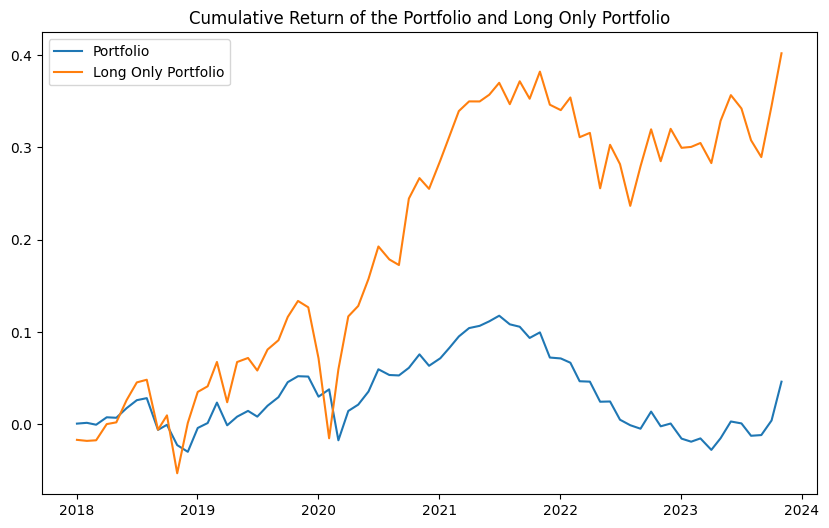

In [24]:
# Draw the line chart of the cumulative return of the portfolio and the long only portfolio
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(portfolio_cumulative_return, label='Portfolio')
plt.plot(portfolio_cumulative_return_long_only, label='Long Only Portfolio')
plt.legend()
plt.title('Cumulative Return of the Portfolio and Long Only Portfolio')
plt.show()

From the result we can see that the long-only portfolio gernerates much better annual returns and total return than the long-and-short strategy. The reasons may be:
1.  The stock market tends to have an upward bias over time, with stocks exhibiting more upside potential than downside risk.
2. The regression models used to predict laggard stock returns may have had more difficulty accurately forecasting negative returns compared to positive returns.

## Limiations and Further Improvement

1. To enhance the model, we could explore more sophisticated regression techniques, such as non-linear models (e.g., polynomial regression, decision trees, neural networks) or ensemble methods (e.g., random forests, boosting).
2. Based on the regression analysis above, we can see there are some leader stocks actually cannot predict the trends of the laggard stocks. We could work on how to improve the selection of the leader stocks.
3. In the current approach, we simply choose the leader stocks as those with a correlation difference larger than 0.1. While this is straightforward, we could explore more proper methods or filters to select the leader stocks.
4. As we only used the tickers from S&P500, one potential enhancement could be to explore the linkages between large-cap and small-cap stocks, as the larger-cap stocks may have stronger informational or behavioral influences on the smaller-cap names.